# Formalia:

Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2024/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday October 1st, 2024 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via DTU Learn

In [1]:
import random
import os
import re

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from IPython.display import Image, display

# Part 1: Exploring the friendship paradox. 

This first part draws on the friendship paradox exercise from Week 3. You should provide solutions to the following exercises from **Part 3** of that week.

* *The friendship paradox in BA networks*
* *The friendship paradox more generally*
* *The friendship paradox and the configuration model*
* *Growth without preferential attachment*


> A. The friendship paradox in BA networks
> * Pick a node $i$ at random (e.g. use `random.choice`). [Find its degree](https://networkx.github.io/documentation/stable/reference/classes/generated/networkx.Graph.degree.html).
> * Find $i$'s [neighbors](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.Graph.neighbors.html?highlight=neighbors#networkx.Graph.neighbors). And calculate their average degree.
> * Compare the two numbers to check if it's true that $i$'s friends (on average) have more friends than $i$.
> * Do this 1000 times. How many out of those 1000 times is the friendship paradox true in **F-BA**?


**We begin by creating our own Barabási-Albert model**, as outlined at the start of the Week 3 notebook. This process starts with the initialization of a small connected graph comprising five nodes. Subsequently, as new nodes are introduced, the code employs a preferential attachment strategy. This means that nodes with higher degrees (a greater number of connections) have an increased likelihood of forming new links. For each new node, up to a total of 5000, the code calculates the probability of connection based on the degrees of existing nodes and connects the new node to three existing ones.

**The initial selection of parameters was conducted to ensure an accurate power-law distribution, closely aligning with the theoretical values expected of this network type. This will be further discussed in following sections.**


In [2]:
# The Friendship Paradox in BA networks

# Initialize the Barabási-Albert network 
n_nodes = 5000
m_edges = 3  # Increasing the number of edges attached from each new node
random.seed(123)

# Start with a small connected network (m_0 nodes)
m_0 = 5 
ba = nx.Graph()
for i in range(m_0):
    for j in range(i + 1, m_0):
        ba.add_edge(i, j)

# Preferential attachment
for new_node in range(m_0, n_nodes):
    degrees = np.array([ba.degree(n) for n in ba.nodes])
    degree_sum = np.sum(degrees)

    # Compute the probability of connecting to each existing node
    probabilities = degrees / degree_sum

    # Choose m existing nodes to connect to based on the probabilities
    targets = np.random.choice(ba.nodes, size=m_edges, replace=False, p=probabilities)

    # Add edges between the new node and the chosen targets
    for target in targets:
        ba.add_edge(new_node, target)


**The Friendship Paradox** is a phenomenon that posits that, on average, an individual's friends have more friends than the individual does [1]. This was determined by selecting a random node and then examining its neighbors. We calculated the degree of that node and the average degree of its neighbors for comparison.

After repeating this process 1000 times, we observed some variability depending on the random initialization. However, we concluded that **the Friendship Paradox holds true in 90% of the cases in our Barabási–Albert network.**

In [3]:
# Function to test the friendship paradox for a random node
def test_friendship_paradox(G):
    # Choose a random node
    node = random.choice(list(G.nodes()))
    node_degree = G.degree[node]
    # Get neighbors of the node and calculate their average degree
    neighbors = list(G.neighbors(node))
    if neighbors:
        neighbors_degrees = [G.degree[neighbor] for neighbor in neighbors]
        avg_neighbors_degree = np.mean(neighbors_degrees)
        # Compare the if it is true that the neighbors have more "friends" than the random node
        return avg_neighbors_degree > node_degree
    # If node has no neighbors
    return False 

# Run the experiment 1000 times
num_trials = 1000
paradox_true_count = sum(test_friendship_paradox(ba) for _ in range(num_trials))

# Calculate the fraction of times the paradox is true
fraction_paradox_true = paradox_true_count / num_trials

# Part A result
print(f"Friendship paradox is true {fraction_paradox_true*100}% of the time")

Friendship paradox is true 88.2% of the time


> B. The friendship paradox more generally
> * What if the power law is flatter, e.g. $p(k) \sim k^{-\gamma}$ with $\gamma = 2$? Will the fraction of times the paradox is true be higher or lower? 
>  - First answer this question by simply reasoning. Think about what it would mean in terms of hubs that the power law is flatter? 
>  - Now simulate a new network with the slope mentioned above. You can generate networks with power-law degree distributions using the [configuation model](https://en.wikipedia.org/wiki/Configuration_model). The `networkx` funtion is here [`nx.configuration_model`](https://networkx.org/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html). I suggest you make the network pretty big ... let's say 5000 nodes or more.
>     * Hint 0: In the `networkx` function mentioned above, you need a degree sequence. This can be created using the so-called transformation method. If we can generate a random real number $r$ uniformly distributed in the range $0 \leq r < 1$, then $x = x_{\textrm{min}}(1 – r)^{-1/\alpha - 1}$ is a random power-law-distributed real number in the range $x_{\textrm{min}} \leq x < \infty$ with exponent $\alpha$. Note that there has to be a lower limit $x_\textrm{min}$ on the range; the power-law distribution diverges as $x\rightarrow 0$. See [this paper](https://www.cs.cornell.edu/courses/cs6241/2019sp/readings/Newman-2005-distributions.pdf) for more details.
>     * Hint 1: The sequence generated using the method mentioned above consists of real numbers, we need integers, so it needs to be rounded as well.
>     * Hint 2: Also, due to some details of how the configuation works (see the [wiki page](https://en.wikipedia.org/wiki/Configuration_model) for details), the sequence cannot have a sum which is an odd number, so if your sequence turns out odd, just choose an element and add 1 to its degree, that way the sum will be an even number.
> - Did you reason correctly above? For what fraction of the time is the friendship paradox true for your network with a new slope? 

In social networks we would find that the number of connections a node has doesn't follow a random pattern but a power law. Thus, there will be few nodes with a high number of connections known as hubs, and most of the nodes will have few connections. When the power law is flatter, we refer to a case when the largest hub has even more connections than they would do in a steeper power law distribution.
In this context, we would see that **in a network with power flatter distribution almost every node is connected to the largest hub, thus, the degree of this node will be greater than the average degree of the nodes in the network as a whole**. Applying this to friendship, on average our friends have more friends than we do. Thus, we expect that the flatter the network, the higher the probability of the Friendship Paradox to be true.

Now we will test the Friendship Paradox using the Configuration Model. The function starts by generating 5000 random real numbers (r) uniformly distributed between 0 and 1. It then uses the transformation method to create a sequence of degrees following a power-law distribution with a given exponent alfa and a lower bound. These degrees are converted to integers. Since the degree sequence must have an even sum, a requirement for the configuration model to work, if the sum of the degrees is odd, the code adds an extra degree of 1 to ensure the sum is even. Finally, the degree sequence is passed.

In [4]:
def configuration(alfa):
    x_min = 1
    r = np.random.uniform(size = 5000)
    x = (x_min*(1-r)**(-1/alfa -1)).astype(int)
    if np.sum(x)%2 != 0: 
        x = np.append(x, 1)

    configuration = nx.configuration_model(x)
    return configuration

def friendship_paradox_rate(configuration, n_nodes):

    nodes = np.random.choice(list(configuration.nodes), size = n_nodes)
    degrees_nodes = [configuration.degree[node] for node in nodes]
    degree_friend = []
    for node in nodes:
        friend_list = []
        for neigh in list(configuration.neighbors(node)):
            friend_list += [configuration.degree[neigh]]
        degree_friend += [np.average(friend_list)]
    true = (sum(np.array(degree_friend)> np.array(degrees_nodes)))
    return true 

flatter_configuration = configuration(2)
rate = friendship_paradox_rate(flatter_configuration, 1000)
print(f"Friendship paradox was true {rate} times, so {rate/1000*100}% of the time")

Friendship paradox was true 991 times, so 99.1% of the time


In this case, we see that the **friendship paradox is true for almost 100% of the times.**

C. The Friendship Paradox and the Configuration Model
> - Now generate a network for the configuration model that has *the same slope and number of nodes as **F-BA** in A above*; let's call this new network **F-CM** (for *friendship configuration model*). 
>    - What fraction of the time is the friendship paradox is true for the **F-CM** network? 
>    - Assuming that **F-BA** and **F-CM** have the same degree sequence can now *think* about if **F-BA** and **F-CM** are different with respect to the friendship paradox. Specifically, please explain your thoughts on the following topics
>       * Are there factors beyond the degree-distribution that could impact how frequently the friendship paradox is true? I might consider how network properties like assortativity, clustering, community-structure, etc potentially could impact things (it's OK to search online and add references to your answer). 

>  * How would you test more rigorously if the friendship-paradox is actually true equally often in **F-BA** and **F-CM**? (E.g. how would you run a statistical test to investigate ... or how would you put error-bars on your plots?) 

As we mentioned in the guide book: "The Barabasi model predicts a power law exponent of 3 while the degree exponent of real networks varies between 2 and 5". **A power-law exponent of around 3 means that it has a steep power-law distribution, rather than a flatter one.** This is important because it causes that number of high-degree hubs is smaller and they are less dominant in the network than in if the exponent was 2.

We will first check the gamma value of the Albert-Barabasi network we generated. In the figure below, howed compares the observed degree distribution (blue) with the fitted power-law distribution (red). If the BA network follows a power law with an exponent of 3, the blue line should match the slope of the red dashed line, which is our case. 
Still, the power law exponent is 3.05, which is very close to the theoretical value. Although some deviations are visible, particularly at the extremes, this is normal due to network size and random fluctuations in the data.


Estimated power-law exponent (gamma): 3.0404063978599174


Calculating best minimal value for power law fit
c:\Users\famu\miniconda3\envs\famu\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


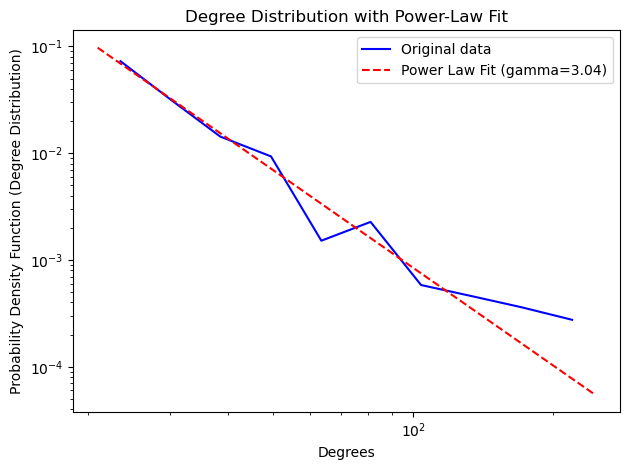

In [5]:
# needs powerlaw installed
import powerlaw
import matplotlib.pyplot as plt

# Get degree distribution
degree_sequence = sorted([d for n, d in ba.degree()], reverse=True)

# Fit power law
fit = powerlaw.Fit(degree_sequence)

# Extract the estimated power-law exponent
gamma = fit.power_law.alpha
print(f"Estimated power-law exponent (gamma): {gamma}")

# Plot the degree distribution with the power-law fit
fig, ax = plt.subplots()
fit.plot_pdf(color='b', label='Original data', ax=ax)
fit.power_law.plot_pdf(color='r', linestyle='--', label=f'Power Law Fit (gamma={gamma:.2f})', ax=ax)

# Add title and labels
ax.set_title('Degree Distribution with Power-Law Fit')
ax.set_xlabel('Degrees')
ax.set_ylabel('Probability Density Function (Degree Distribution)')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


**Now we generate a network for the configuration model that has the same slope and number of nodes as the initial Barabasi-Albert Network.** Then, we test for the Friendship Paradox as we did before.

In [6]:
# Extract the degree sequence from F-BA (G)
degree_sequence = [degree for node, degree in ba.degree()]

# Part 1: Create the F-CM (Friendship Configuration Model) using the degree sequence
G_FCM = nx.configuration_model(degree_sequence)

# Test friendship 
paradox_true_count = sum(test_friendship_paradox(G_FCM) for _ in range(num_trials))

# Calculate the fraction of times the paradox is true
fraction_paradox_true_fcm = paradox_true_count / num_trials

# Part A result
print(f"Friendship paradox for the FCM is true {fraction_paradox_true_fcm*100}% of the time")


Friendship paradox for the FCM is true 91.0% of the time


Now that we changed the slope of the of the Configuration Model **we see that the Friendship Paradox is true approximately 90% of the time, while before it was 100%.**

In considering the factors that influence the prevalence of the friendship paradox beyond degree-distribution, we have to examine network properties such as **assortativity**. Assortativity, specifically, is a measure of a network's tendency to connect nodes with similar properties, like degree [3]. Networks with high assortativity are characterized by high-degree nodes that are more likely to be connected to other high-degree nodes. This contrasts with BA networks, which exhibit disassortativity, meaning that nodes with a low degree are more commonly linked to high-degree nodes. Conversely, CM networks display neutral assortativity, which results in a less pronounced friendship paradox. These network properties can significantly affect the frequency of the friendship paradox's occurrence.

To more rigorously test the prevalence of the friendship paradox in both F-BA and F-CM networks, one could employ a **chi-square test to compare the proportions of nodes that exhibit the paradox**. This statistical test would determine if there is a significant difference in the occurrence of the friendship paradox between the two network types. Additionally, **quantifying the friendship paradox can be achieved by calculating the discrepancy between a node's characteristics and the average characteristics of its neighbors**. This approach would provide a clearer understanding of the paradox's extent within the networks.

D. Growth without preferential attachment

> Finally, we'll build a network of same size and degree as in the exercise above, *using the growth mechanism without the preferential attachment*. Follow the steps below for success
> 
>  1. Grow a new network (the Sune-network) with the same parameters as the **F-BA** network in the exercise above, i.e. 5000 nodes, each new node connects to the existing network, but with one key difference: *have the incoming nodes connect to the existing nodes with* **equal probability**. This is the Sune-network.
>  2. Generate an ER network of same number of nodes and links as the Sune-network. 
> * What are the differences between the ER network and the Sune-network? Explain in your own words. 

>   * *Hints*: To get started, plot the two degree distribution in the same plot. Compare and contrast. Another revealing network property to study is the the number of connected components.

In [7]:
# Generate the Sune Network
random.seed(123)
sune = nx.Graph()
sune.add_node(1)
for i in range(2,5000):
    sune.add_edge(i, np.random.choice(list(sune.nodes)))
# Generate ER Network
er = nx.erdos_renyi_graph(5000, 1/5000)


**The Sune-Network grows similarly to BA network but without preferential attachment**, it has random attachment. On the other hand, the ER network doesn't grow in a step-by-step fashion like the Sune one. 

**Sune Network** has longer tail, it **includes nodes with higher degrees**. In ER networks, the degree distribution is concentrated in lower values.

Regarding the assortativity of the networks, since the **Sune-network has a degree of assortativity of close to 0, but still negative, and the ER network has one of 0.025**. The near-zero assortativity in the Sune-network indicates a more random connection pattern compared to the ER network. This can also be infered from the degree distribution plot, where we can see that the Sune network maintains a flatter distribution, while the ER network has a more varied distribution.

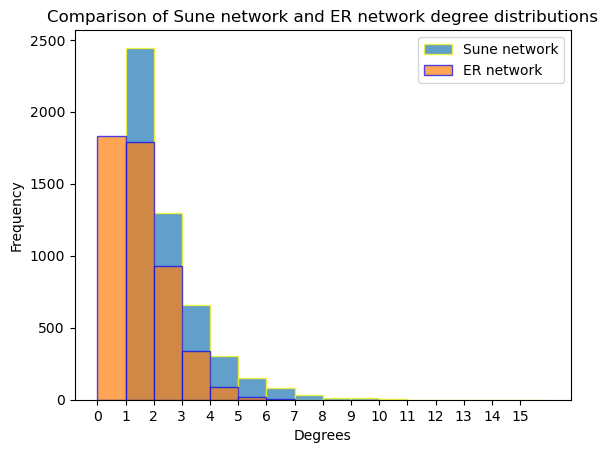

Degree Assortativity for Sune: -0.0133218049816279
Degree Assortativity for ER: 0.025289966025939584


In [8]:
sune_degrees = [x[1] for x in sune.degree]
max_sune = sorted(sune_degrees, reverse=True)[0]
min_sune = sorted(sune_degrees)[0]
bins_su = np.array(range(min_sune, max_sune+2))

er_degrees = [x[1] for x in er.degree]
max_er= sorted(er_degrees, reverse=True)[0]
min_er = sorted(er_degrees)[0]
bins_er = np.array(range(min_er, max_er+2))

plt.hist(sune_degrees, edgecolor='yellow', bins=bins_su, label = "Sune network", alpha = 0.7)
plt.hist(er_degrees, edgecolor='blue', bins=bins_er, label = "ER network", alpha = 0.7)
plt.title("Comparison of Sune network and ER network degree distributions")
plt.legend(loc='upper right')
plt.xticks(np.arange(min(sune_degrees)-1, max(sune_degrees)+1, 1.0))
plt.xlabel('Degrees')
plt.ylabel('Frequency')

plt.show()

assortativity = nx.degree_assortativity_coefficient(sune)
print(f"Degree Assortativity for Sune: {assortativity}")
assortativity = nx.degree_assortativity_coefficient(er)
print(f"Degree Assortativity for ER: {assortativity}")

# Part 2A: Stats of the Country Music Network

This second part requires you to have built the network of Country Musicians as described in the exercises for Week 4. You should complete the following exercise from **Part 2**.

* *Simple network statistics and analysis*

And the following exercise from **Part 3**

* *Let's build a simple visualization of the network*

And that's it! You're all set.


---------------------------------------------

> *Exercise*: Simple network statistics and analysis

> * What is the number of nodes in the network? 
> * More importantly, what is the number of links? (Chat with a fellow student or a TA to make sure you're in the right ball-park)
> * Plot the in and out-degree distributions for the entire network. What do you observe? Can you explain why the in-degree distribution is different from the out-degree distribution?
>     * Compare the out-degree distribution to a *random network* with the same number of nodes and links.
>     * Compare the in-degree distribution to a *scale-free* network with the same number of nodes.
> * Who are the top 5 most connected performers (Report results for in-degrees and out-degrees, that is, who has highest in-degree, who has highest out-degree)? Comment on your findings. Is this what you would have expected?
> * What are the 10 pages with the longest wiki entries? (use the `length of content` attribute to figure this one out)?

<div class="alert alert-block alert-info">
For this exercise, I hope you'll do everything yourself. This is a part where you learn something by writing the code.
</div>

In [9]:
output_dir='./country_performers'
raw_performers = [file.replace('_', ' ').replace('.txt', '') for file in os.listdir(output_dir) if file.endswith('.txt')]
raw_performers = [performer.replace(' ', '_') for performer in raw_performers]  



# In the dataset there are some keywords that are not performers, we exclude them
keywords_to_exclude = ["List", "Country_music", "Country_Music_Hall_of_Fame", "List_of_country_music_performers", 
"List_of_country_performers", "List_of_country_music_performers_by_genre",]
performers = [performer for performer in raw_performers if not any(keyword in performer for keyword in keywords_to_exclude)]


In [10]:
print("Number of performers: ", len(performers))

Number of performers:  2103


In [11]:
def count_words(content):
    # Regular expression to find words
    words = re.findall(r'\b\w+\b', content)
    return len(words)

def extract_links(page_content, performers):
    # Regular expression to find links within double square brackets [[...]]
    links = re.findall(r'\[\[([^\]|]+)', page_content)
    # Filter links to keep only those in the performers list
    filtered_links = [link.replace(' ', '_') for link in links if link.replace(' ', '_') in performers]
    return filtered_links

In [12]:
# Create a directed graph
G = nx.DiGraph()

for performer in performers:
    # Read the content of the file
    file_path = os.path.join(output_dir, f"{performer.replace('_', ' ')}.txt")
    
    with open(file_path, 'r', encoding='utf-8') as f:
        page_content = f.read()
        
    # Extract links from the page content
    links = extract_links(page_content, performers)
    
    # Add node with word count as an attribute
    word_count = len(re.findall(r'\b\w+\b', page_content))
    content_length = len(page_content)
    G.add_node(performer, word_count=word_count, content_length=content_length)
    
    # Add edges to the graph, only if the link (performer/person) is in the performers list
    for link in links:
        if link not in G.nodes():
            G.add_node(link)
        G.add_edge(performer, link)

# Remove isolated nodes
isolated_nodes = [node for node in G.nodes() if G.out_degree(node) == 0 and G.in_degree(node) == 0]
G.remove_nodes_from(isolated_nodes)

> * What is the number of nodes in the network? 

In [13]:
total_nodes = G.number_of_nodes()
print(f"Total number of nodes in the network: {total_nodes}")

Total number of nodes in the network: 1883


> * More importantly, what is the number of links? (Chat with a fellow student or a TA to make sure you're in the right ball-park)


In [14]:
total_edges = G.number_of_edges()
print(f"Total number of edges (links) in the network: {total_edges}")

Total number of edges (links) in the network: 16968


> * Plot the in and out-degree distributions for the entire network. What do you observe? Can you explain why the in-degree distribution is different from the out-degree distribution?

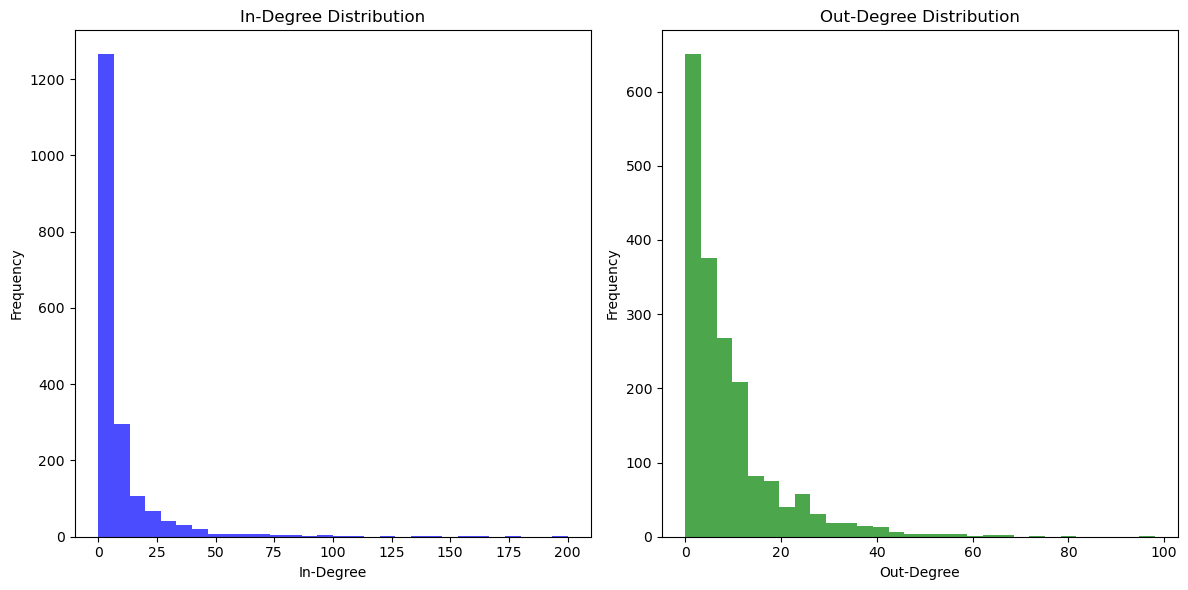

In [15]:
in_degrees = [G.in_degree(n) for n in G.nodes()]
out_degrees = [G.out_degree(n) for n in G.nodes()]

#in-degree distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=30, color='blue', alpha=0.7)
plt.title('In-Degree Distribution')
plt.xlabel('In-Degree')
plt.ylabel('Frequency')

#out-degree distribution
plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=30, color='green', alpha=0.7)
plt.title('Out-Degree Distribution')
plt.xlabel('Out-Degree')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

> As it can be seen above, the in-degree and out-degree distributions are different. The majority of artists appear on a range of 0-50 approximately, which means that most of the artists have been influenced by 0 to 50 other artists; which also means that the influence is spread out among many artists. This could be for several reasons like for exmaple the popularity of the artists: there could be a famous country artist that is more popular or influential, leading to a higher in-degree. Also, the amount of collaborations between artists influence the out-degree grade; if they collaborate with many others or reference many other artists, higher out-degree. [4]

> Long tail distributions may show that ountry music industry is dominated by a few key players; whether due to their popularity, industry control, or prolific collaboration behavior.

> Artists that plays a sub-genres might reference each other more frequently, leading to higher in-degrees within those sub-genres. Some artists might do multiple sub-genres, leading to a higher out-degree because they collaborate with artists from different sub-genres.

> Also, it can be seen that the frequency of out-degree for the interval between 0-5 has a value approx of more than 650, which is interesting as it shows us that most of the artist in the country music industry collaborate with or influence very few other artists.

> The high frequency of artists with low out-degrees (0-5) suggests that many country artists are either emerging or remain relatively niche. These artists may be in the early stages of their careers, have fewer opportunities for collaboration, or are working in independent or local scenes.

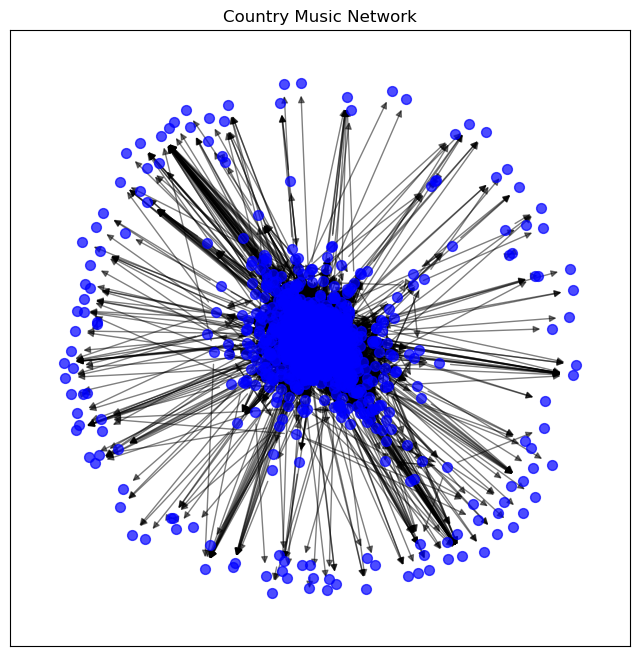

In [16]:
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)  
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue', alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("Country Music Network")
plt.show()

**Plots below this cell**
>     Compare the in-degree distribution to a *scale-free* network with the same number of nodes.
Our network shares some characteristics of a scale-free structure, with most nodes having few incoming connections and a few nodes acting as hubs with a large number of connections. The alignment between the original and scale-free networks suggests that the country music collaboration network is scale-free to some degree, meaning that a few highly connected artists act as hubs of influence 

>     Compare the out-degree distribution to a *random network* with the same number of nodes and links.

Both (out degree) distributions are skewed toward lower values, our network has a more pronounced tail with a few nodes having higher out-degrees. This suggests that our network is not random, as it displays more variability in node connectivity, indicating an organized structure where certain nodes have significantly more outgoing connections. This shows that in our network there is 'hierarchy' in the sense of influence. The fact that the original network does not resemble a random network suggests that collaborations in the country music industry are strategic and not uniformly distributed


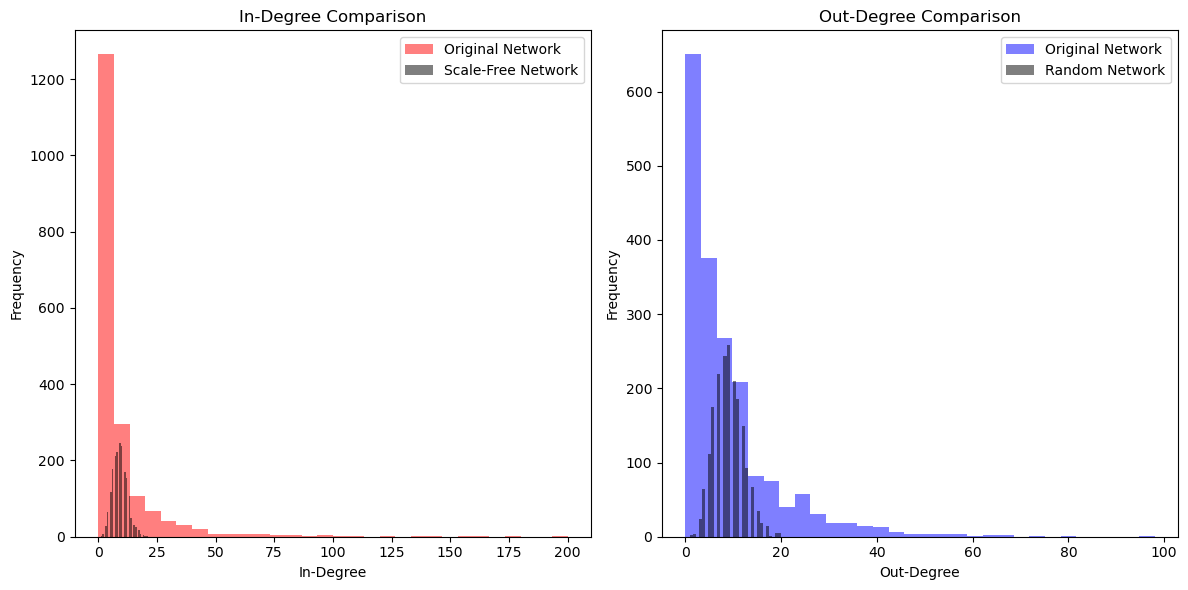

In [17]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

random_graph = nx.gnp_random_graph(num_nodes, num_edges / (num_nodes * (num_nodes - 1)), directed=True)
random_out_degrees = [random_graph.out_degree(n) for n in random_graph.nodes()]

scale_free_graph = nx.barabasi_albert_graph(num_nodes, 2)
scale_free_graph = nx.DiGraph(scale_free_graph) 
scale_free_out_degrees = [scale_free_graph.out_degree(n) for n in scale_free_graph.nodes()]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=30, color='red', alpha=0.5, label='Original Network')
plt.hist(np.random.poisson(lam=np.mean(in_degrees), size=len(in_degrees)), bins=30, color='black', alpha=0.5, label='Scale-Free Network')
plt.title('In-Degree Comparison')
plt.xlabel('In-Degree')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=30, color='blue', alpha=0.5, label='Original Network')
plt.hist(random_out_degrees, bins=30, color='black', alpha=0.5, label='Random Network')
plt.title('Out-Degree Comparison')
plt.xlabel('Out-Degree')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
# Top 5 performers by in-degree
top_in_degrees = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 performers by in-degree:")
for performer, degree in top_in_degrees:
    print(f"{performer}: {degree}")

# Top 5 performers by out-degree
top_out_degrees = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 performers by out-degree:")
for performer, degree in top_out_degrees:
    print(f"{performer}: {degree}")


Top 5 performers by in-degree:
Willie_Nelson: 200
Johnny_Cash: 178
Elvis_Presley: 174
Dolly_Parton: 160
George_Jones: 156

Top 5 performers by out-degree:
Hillary_Lindsey: 98
Pam_Tillis: 80
Randy_Travis: 74
Vince_Gill: 68
Patty_Loveless: 68


As it can be seen, most of the in/out degrees artist are people that is/has been influencial in the industry thus, showing that the netwrok represents the reality. As it can be seen in the next photo, doing a quick search in google [5] , we can see that some of the artists (Willie Nelson, Vince Gill, Jhonny Cash...) that are influential appear in our networks as 'leaders' in terms of in/out degrees distributions therefore, the results were expected.

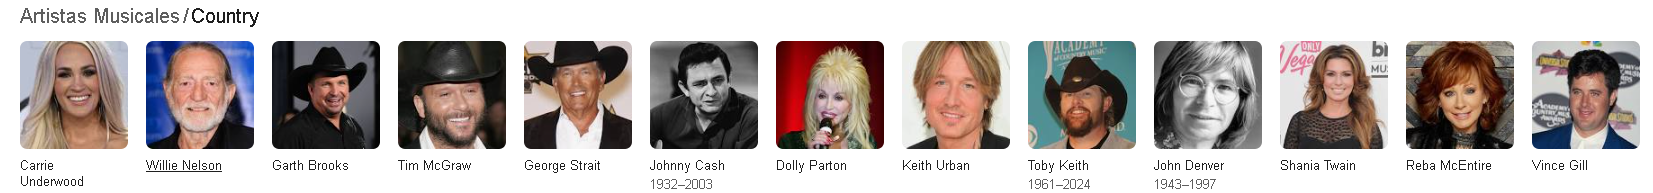

In [19]:

image_path = r'C:\Users\famu\Documents\GitHub\socialgraphs2024\images\countryArtists.PNG'
display(Image(filename=image_path))

The plot shown below shows the top 10 artists per in/out degree. Made for a deeper understading of the network

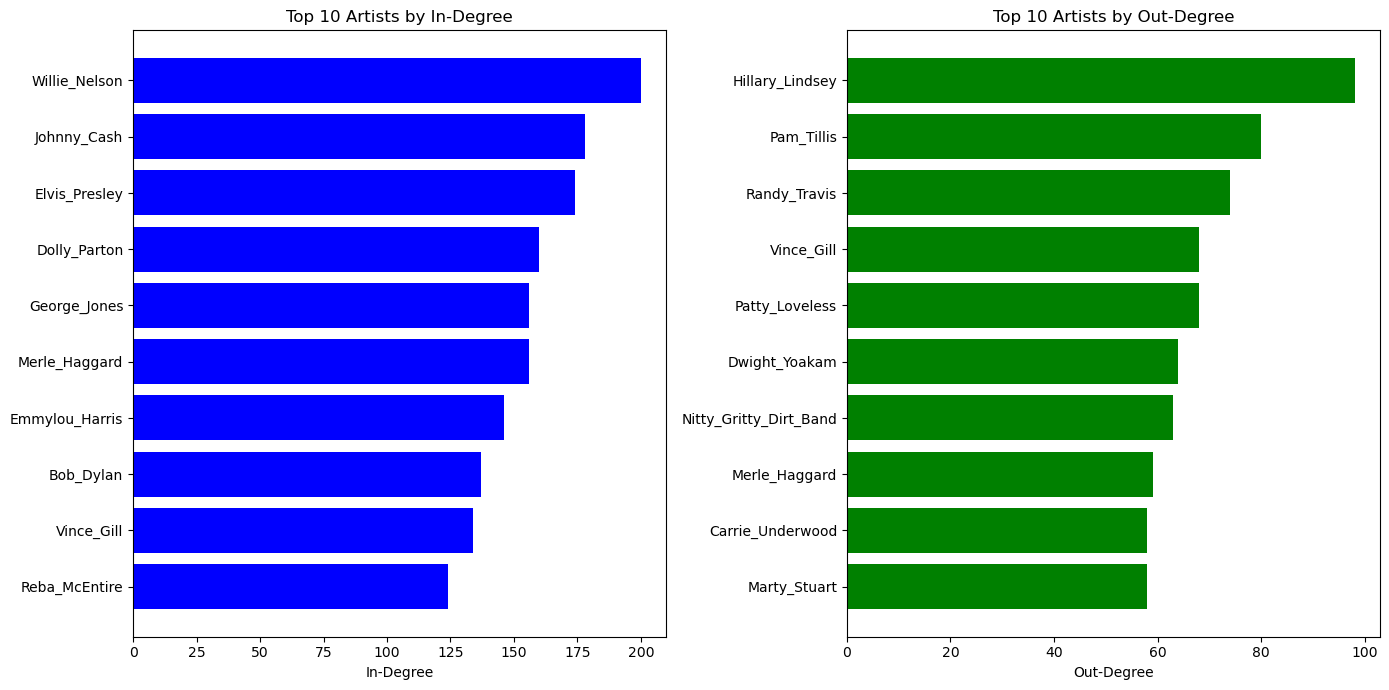

In [20]:
top_10_in_degrees = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:10]
top_10_in_names, top_10_in_values = zip(*top_10_in_degrees)

top_10_out_degrees = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:10]
top_10_out_names, top_10_out_values = zip(*top_10_out_degrees)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.barh(top_10_in_names, top_10_in_values, color='blue')
plt.xlabel('In-Degree')
plt.title('Top 10 Artists by In-Degree')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh(top_10_out_names, top_10_out_values, color='green')
plt.xlabel('Out-Degree')
plt.title('Top 10 Artists by Out-Degree')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

Below, different mesaures of the network are calculate, like degree centrality, betweenness centraility etc...This measures will help us in see if the in/out degrees calculated before makes sense or correspond with what the measures said.


For exmaple, **Willie Nelson** is the one who has more edges conected to itself. He also is the top 1 regarding closeness centrality, which measures the average length of the shortest path from a node to all other nodes in the network. **Jhonny Cash** seems to be as well very influencial in the network, let's do some research; with a quick search in wikipedia we can see that: *Cash is one of the best-selling music artists **of all time**, having sold more than 90 million records worldwide. Considered one of the most influential musicians of the 20th century. Considered **“the King of Country Music”** and an icon of that genre.*  **So, apparently, our network refelcts reality.**

In [21]:
degree_centrality = nx.degree_centrality(G)

betweenness_centrality = nx.betweenness_centrality(G)

closeness_centrality = nx.closeness_centrality(G)

eigenvector_centrality = nx.eigenvector_centrality(G)


centrality_df = pd.DataFrame({
    'Degree Centrality': degree_centrality,
    'Betweenness Centrality': betweenness_centrality,
    'Closeness Centrality': closeness_centrality,
    'Eigenvector Centrality': eigenvector_centrality
})

top_degree_centrality = centrality_df['Degree Centrality'].nlargest(10)
top_betweenness_centrality = centrality_df['Betweenness Centrality'].nlargest(10)
top_closeness_centrality = centrality_df['Closeness Centrality'].nlargest(10)
top_eigenvector_centrality = centrality_df['Eigenvector Centrality'].nlargest(10)

print("Top 10 artists by Degree Centrality:")
print(top_degree_centrality)

print("\nTop 10 artists by Betweenness Centrality:")
print(top_betweenness_centrality)

print("\nTop 10 artists by Closeness Centrality:")
print(top_closeness_centrality)

print("\nTop 10 artists by Eigenvector Centrality:")
print(top_eigenvector_centrality)

Top 10 artists by Degree Centrality:
Willie_Nelson     0.131775
Johnny_Cash       0.117428
Merle_Haggard     0.114240
George_Jones      0.111583
Dolly_Parton      0.108927
Vince_Gill        0.107333
Emmylou_Harris    0.104145
Elvis_Presley     0.103613
Reba_McEntire     0.087141
Hank_Williams     0.086079
Name: Degree Centrality, dtype: float64

Top 10 artists by Betweenness Centrality:
Vince_Gill          0.036187
Merle_Haggard       0.035821
Willie_Nelson       0.032489
Toby_Keith          0.028673
Johnny_Cash         0.028056
George_Jones        0.025853
Dolly_Parton        0.025698
Keith_Urban         0.024119
Carrie_Underwood    0.023484
Emmylou_Harris      0.022997
Name: Betweenness Centrality, dtype: float64

Top 10 artists by Closeness Centrality:
Willie_Nelson     0.420154
Elvis_Presley     0.416498
Johnny_Cash       0.415860
Merle_Haggard     0.413534
Dolly_Parton      0.413010
Vince_Gill        0.410613
George_Jones      0.405194
Emmylou_Harris    0.397377
Reba_McEntire     

> * What are the 10 pages with the longest wiki entries? (use the `length of content` attribute to figure this one out)?


In [22]:
content_lengths = nx.get_node_attributes(G, 'content_length')

sorted_performers = sorted(content_lengths.items(), key=lambda x: x[1], reverse=True)

top_10_longest_entries = sorted_performers[:10]

print("Top 10 performers with the longest wiki entries:")
for performer, length in top_10_longest_entries:
    print(f"{performer}: {length} characters")

Top 10 performers with the longest wiki entries:
Taylor_Swift: 361338 characters
Miley_Cyrus: 320182 characters
Justin_Bieber: 317922 characters
Justin_Timberlake: 287161 characters
Carrie_Underwood: 286800 characters
Demi_Lovato: 276522 characters
Bob_Dylan: 255508 characters
Ed_Sheeran: 224499 characters
Elvis_Presley: 211986 characters
Tina_Turner: 204432 characters


This is actually super interesting as it can be seen that pop icons like Taylor Swift, Miley Cyrus, and Justin Bieber, whose detailed biographies highlight their massive influence, media presence, and diverse careers across music, film, and social causes.  Legends like Elvis Presley and Bob Dylan showcase the lasting impact of music icons from past generations, whose influence on modern music continues to be widely recognized and discussed. 

# Part 2B: Visualizing the networks

*Exercise:* Let's build a simple visualization of network
>1. For the sake of the visualisation, let's convert our network to *undirected graph* (tip: There is a NetworkX command to help you).
>   * *Note*: Keep the directed graph, we will use it in couple of the following exercises.
>2. Use the NetworkX command `nx.draw_kamada_kawai` to draw the resulting undirected network. (You can find [background on the algorithm here](https://en.wikipedia.org/wiki/Force-directed_graph_drawing).)  
>   * Set up your plot so that node-size depends on the node *degree*.
>   * Make the node color depend on the `length of content` attribute. I recommend choosing a color scheme that is quite simple (e.g. the Sequential ones here: https://matplotlib.org/stable/users/explain/colors/colormaps.html)

<div class="alert alert-block alert-info">
For this exercise, I hope you'll do almost everything yourself. But it's OK to use an LLM for help with the coloring.
</div>

And don't worry if your network looks like a hairball (a.k.a a *ridiculogram*) for now, we'll dig deeper with visualization next time.

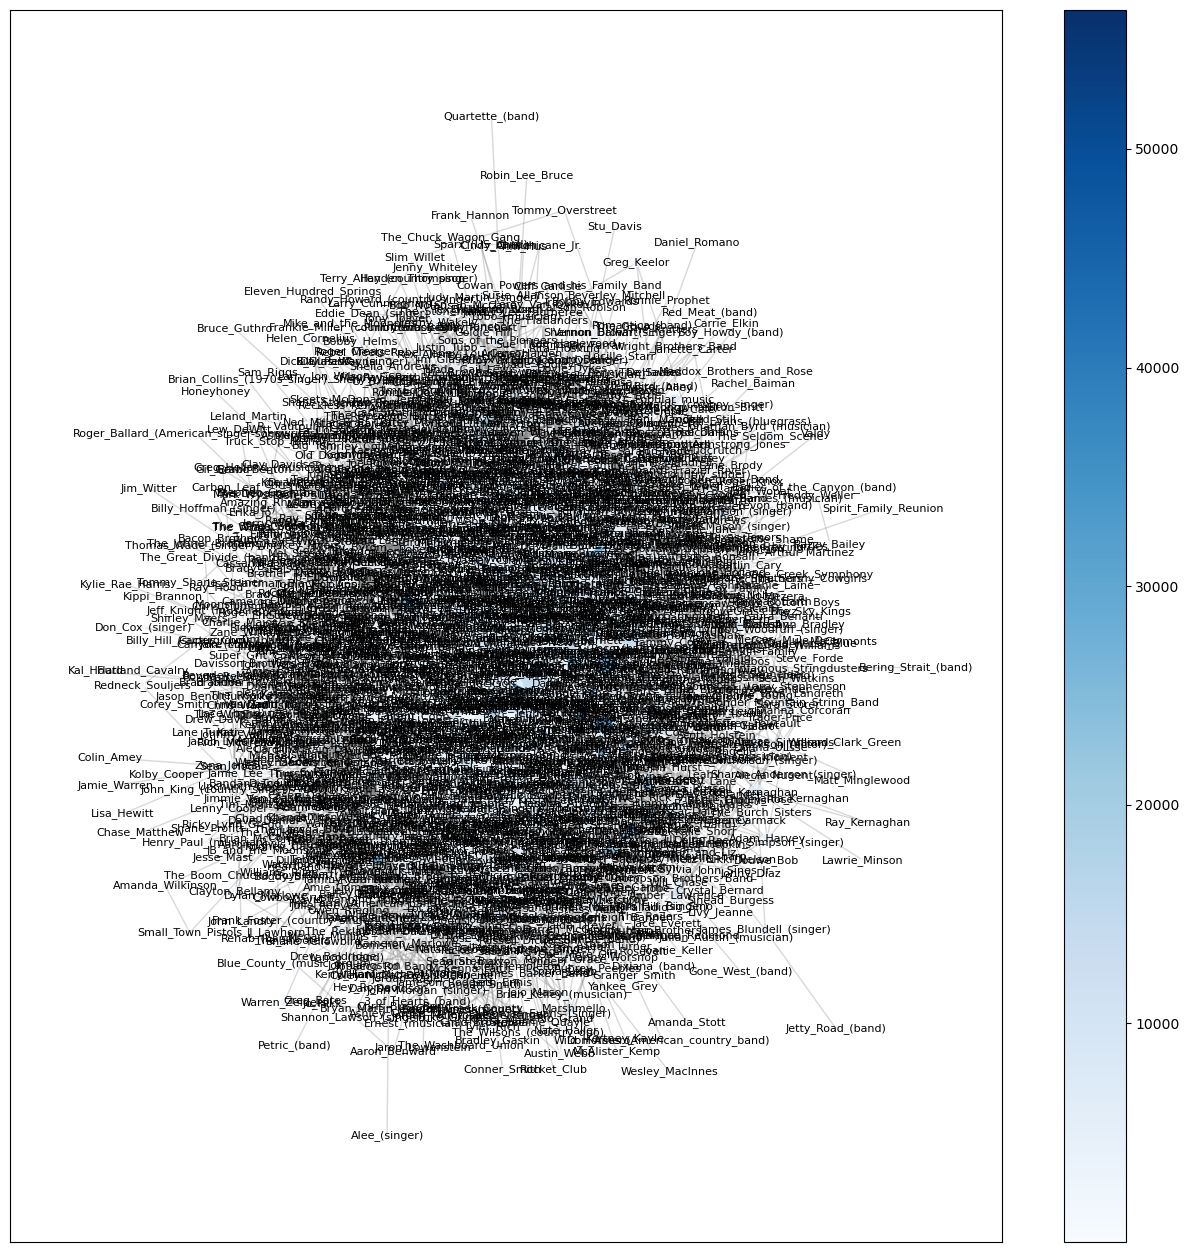

In [25]:
undirected_graph = G.to_undirected()

# Get the degrees (number of connections) of each node
degrees = np.array([undirected_graph.degree(n) for n in undirected_graph.nodes()])

# Get the content lengths of each node (e.g., word_count)
content_lengths = np.array([undirected_graph.nodes[n]['word_count'] for n in undirected_graph.nodes()])

# Normalize content lengths for color mapping
norm_content_lengths = (content_lengths - np.min(content_lengths)) / (np.max(content_lengths) - np.min(content_lengths))

# Define node size based on degrees (number of connections)
node_size = degrees * 10  # Adjust the multiplier to change the node size scaling

plt.figure(figsize=(16, 16))

# Define the layout of the graph
pos = nx.kamada_kawai_layout(undirected_graph)

# Set color map
cmap = plt.get_cmap('Blues')

# Drawing the nodes
nodes = nx.draw_networkx_nodes(undirected_graph, pos, node_size=node_size, 
                               node_color=norm_content_lengths, cmap=cmap, alpha=0.8)

# Drawing the edges
edges = nx.draw_networkx_edges(undirected_graph, pos, alpha=0.3, edge_color='gray')

# Drawing the labels (names of each node)
nx.draw_networkx_labels(undirected_graph, pos, font_size=8, font_color='black')

# Create and configure the color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(content_lengths), vmax=np.max(content_lengths)))
sm.set_array([]) 
cbar = plt.colorbar(sm, ax=plt.gca()) # Color bar


Explanation:

* Node sizes indicate the number of connections for each node (the larger the node, the more connections it has).
* Node color represents the amount of information related to each artist (darker colors indicate more extensive content).

Graph Analysis:

* The large cluster located in the center suggests that there is a high frequency of connections between artists.
* The isolated nodes indicate that these artists have fewer collaborations with other artists.

>"2". Top 10 in degrees musicians representation

In this second analysis, We decided to focus on a subgroup of some of the most popular artists to gain a clearer view of the collaboration dynamics in country music. In the previous graph, the large number of nodes and connections made it difficult to identify significant patterns. This approach helps to better understand the impact of these artists in the musical network.

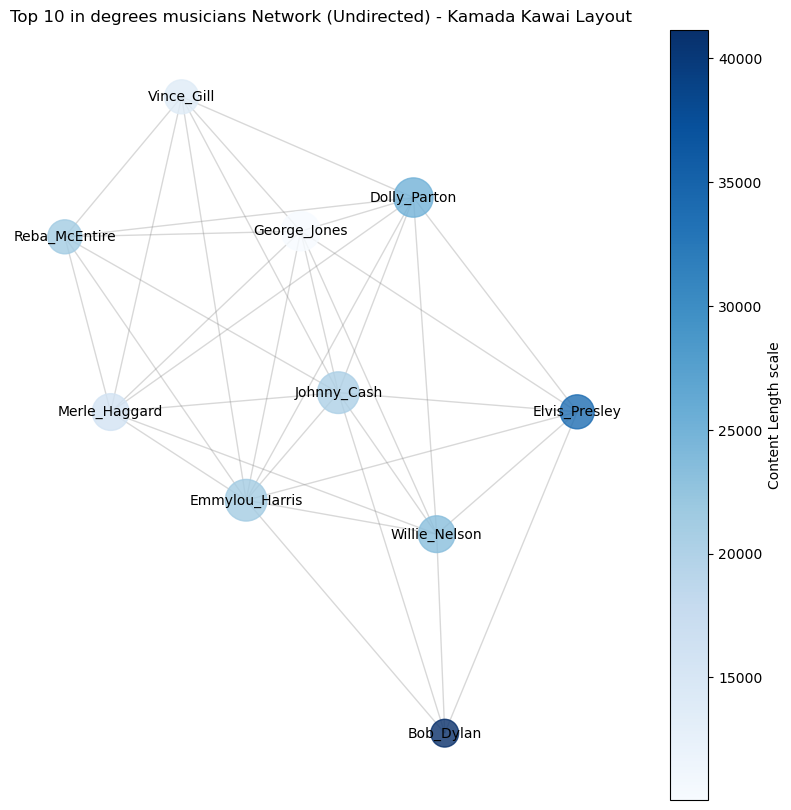

In [26]:
#Subgraph of the Top 10 in degrees musicians creation

top_10_in_degrees = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:10]
top_10_in_names, top_10_in_values = zip(*top_10_in_degrees)
subgraph_nodes = set(top_10_in_names)
subgraph = G.subgraph(subgraph_nodes).copy()

undirected_graph = subgraph.to_undirected()
degrees = np.array([undirected_graph.degree(n) for n in undirected_graph.nodes()])  
content_lengths = np.array([undirected_graph.nodes[n]['word_count'] for n in undirected_graph.nodes()])
norm_content_lengths = (content_lengths - np.min(content_lengths)) / (np.max(content_lengths) - np.min(content_lengths))  

plt.figure(figsize=(10, 10))
pos = nx.kamada_kawai_layout(undirected_graph)  
cmap = plt.get_cmap('Blues')


nodes = nx.draw_networkx_nodes(undirected_graph, pos, node_size=degrees * 100,node_color=norm_content_lengths, cmap=cmap, alpha=0.8)
edges = nx.draw_networkx_edges(undirected_graph, pos, alpha=0.3, edge_color='gray')

nx.draw_networkx_labels(undirected_graph, pos, font_size=10, font_color='black')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(content_lengths), vmax=np.max(content_lengths)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())  
cbar.set_label('Content Length scale') 


plt.title("Top 10 in degrees musicians Network (Undirected) - Kamada Kawai Layout")
plt.axis('off')
plt.show()


Graph Analysis:

* The diversity in connections indicates that collaborations between these artists are common.
* The darkest colored nodes, such as Elvis Presley and Bob Dylan, signify their high popularity.
* The interconnections between artists like Willie Nelson, Dolly Parton, and Emmylou Harris suggest a significant level of collaboration within the genre.

# References

[1]  Feld, Scott L. (1991), "Why your friends have more friends than you do", American Journal of Sociology, 96 (6): 1464–1477, doi:10.1086/229693, JSTOR 2781907, S2CID 56043992.

[2] Cantwell, G. T., Kirkley, A., & Newman, M. E. (2021). The friendship paradox in real and model networks. Journal of Complex Networks, 9(2), cnab011.

[3] Assortativity https://networkx.org/nx-guides/content/algorithms/assortativity/correlation.html#references

[4] Hayes, B. (2000). Computing science: Graph theory in practice: Part I. American Scientist, 88(1), 9-13.

[5] Country Music artists https://www.last.fm/tag/country/artists